<a href="https://colab.research.google.com/github/Ananya616/Projects/blob/master/Image-Generator/MNIST_datset_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Deepfakes with Keras


# Task 1: Importing Libraries and Helper Functions

Please note: If you haven't already, please install the required packages by executing the code cell below.

In [1]:
!pip3 install tensorflow==2.1.0 pillow matplotlib
!pip3 install git+https://github.com/am1tyadav/tfutils.git

     |████████████████████████████████| 421.8MB 19kB/s 
     |████████████████████████████████| 3.9MB 33.6MB/s 
     |████████████████████████████████| 450kB 35.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=9f3ab48b53308610d3751b32effae641cc6f7213d9fbe351f78652a51b680f8f
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: 

In [3]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import os
import tfutils

from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Reshape, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from PIL import Image

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.1.0


# Task 2: Importing and Plotting the Data

In [4]:
(x_train, y_train), (x_test, y_test) = tfutils.datasets.mnist.load_data(one_hot=False)

x_train = tfutils.datasets.mnist.load_subset([0], x_train, y_train)
x_test = tfutils.datasets.mnist.load_subset([0], x_test, y_test)

x = np.concatenate([x_train, x_test], axis=0)

11493376/11490434 [==============================] - 0s 0us/step


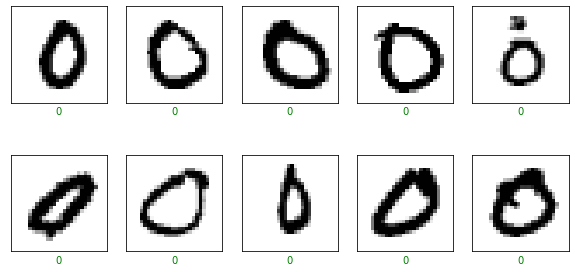

In [5]:
tfutils.datasets.mnist.plot_ten_random_examples(plt, x, np.zeros((x.shape[0], 1))).show()

# Task 3: Discriminator



In [7]:
size = 28
noise_dim = 1

discriminator = Sequential([
    Conv2D(64, 3, strides=2, input_shape=(28, 28, 1)),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(128, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(256, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),
    
    Flatten(),
    Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(lr=2e-4, beta_1=0.5)

discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 13, 13, 64)        640       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 5, 5, 128)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 5, 5, 128)         512       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 256)        

# Task 4: Generator

In [8]:
generator = Sequential([
    Dense(256, activation='relu', input_shape=(noise_dim,)),
    Reshape((1, 1, 256)),
    
    Conv2DTranspose(256, 5, activation='relu'),
    BatchNormalization(),
    Conv2DTranspose(128, 5, activation='relu'),
    BatchNormalization(),

    Conv2DTranspose(64, 5, strides=2, activation='relu'),
    BatchNormalization(),
    Conv2DTranspose(32, 5, activation='relu'),
    BatchNormalization(),

    Conv2DTranspose(1, 4, activation='sigmoid')

])

generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               512       
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 5, 256)         1638656   
_________________________________________________________________
batch_normalization_6 (Batch (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 9, 9, 128)         819328    
_________________________________________________________________
batch_normalization_7 (Batch (None, 9, 9, 128)         512       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 21, 21, 64)       

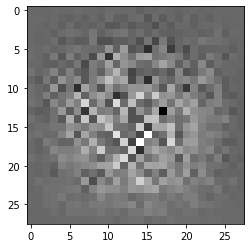

In [9]:
noise = np.random.randn(1, noise_dim)
gen_image = generator.predict(noise)[0]

plt.figure()
plt.imshow(np.reshape(gen_image, (28, 28)), cmap='binary');

# Task 5: Generative Adversarial Network (GAN)

In [10]:
input_layer = tf.keras.layers.Input(shape=(noise_dim,))
gen_out = generator(input_layer)
disc_out = discriminator(gen_out)

gan = Model(
    input_layer,
    disc_out
)

discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         2717025   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1027073   
Total params: 3,744,098
Trainable params: 2,716,065
Non-trainable params: 1,028,033
_________________________________________________________________


# Tasks 6 and 7: Training the GAN

Steps per epoch= 107
CPU times: user 4min 30s, sys: 38.9 s, total: 5min 9s
Wall time: 6min 45s


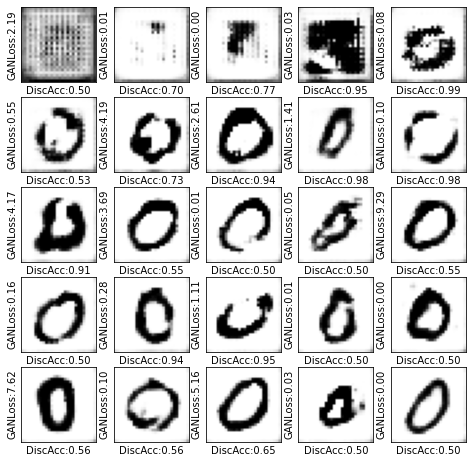

In [11]:
%%time

epochs = 25
batch_size = 128
steps_per_epoch = int(2 * x.shape[0]/batch_size)

print('Steps per epoch=', steps_per_epoch)

dp = tfutils.plotting.DynamicPlot(plt, 5, 5, (8, 8))

for e in range(0, epochs):
    
    dp.start_of_epoch(e)
    
    for step in range(0, steps_per_epoch):
        true_examples = x[int(batch_size/2)*step: int(batch_size/2)*(step + 1)]
        true_examples = np.reshape(true_examples, (true_examples.shape[0], 28, 28, 1))

        noise = np.random.randn(int(batch_size/2), noise_dim)
        generated_examples = generator.predict(noise)

        x_batch = np.concatenate([generated_examples, true_examples], axis=0)
        y_batch = np.array([0] * int(batch_size/2) + [1] * int(batch_size/2))

        indices = np.random.choice(range(batch_size), batch_size, replace=False)
        x_batch = x_batch[indices]
        y_batch = y_batch[indices]

        # train the discriminator
        discriminator.trainable = True
        discriminator.train_on_batch(x_batch, y_batch)
        discriminator.trainable = False

        # train the generator
        loss, _ = gan.train_on_batch(noise, np.ones((int(batch_size/2), 1)))

        _, acc = discriminator.evaluate(x_batch, y_batch, verbose=False)

    noise = np.random.randn(1, noise_dim)
    generated_example = generator.predict(noise)[0]
    
    dp.end_of_epoch(np.reshape(generated_example, (28, 28)), 'binary',
                   'DiscAcc:{:.2f}'.format(acc), 'GANLoss:{:.2f}'.format(loss))